# Model Selection and Comparison

This notebook compares different machine learning algorithms for brain activity classification.

## Objectives:
- Prepare data for modeling
- Implement multiple ML algorithms
- Compare model performance
- Select the best performing model
- Tune hyperparameters
- Evaluate final model

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Prepare Data

In [2]:
# Load the datasets
train_data = pd.read_csv('../data/raw/train_data.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')
test_data = pd.read_csv('../data/raw/test_data.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")

# Get target column
target_column = train_labels.columns[-1]
print(f"Target column: {target_column}")

Training data shape: (159, 22036)
Training labels shape: (159, 1)
Test data shape: (39, 22036)
Target column: 0


In [3]:
# Load problematic features from EDA
try:
    with open('../data/processed/problematic_features.json', 'r') as f:
        problematic_features = json.load(f)
    
    print("Problematic features loaded:")
    print(f"- Constant features: {len(problematic_features['constant_features'])}")
    print(f"- Low variance features: {len(problematic_features['low_variance_features'])}")
    print(f"- Highly correlated pairs: {len(problematic_features['highly_correlated_features'])}")
except FileNotFoundError:
    print("No problematic features file found. Will identify them here.")
    problematic_features = {'constant_features': [], 'low_variance_features': []}

Problematic features loaded:
- Constant features: 0
- Low variance features: 0
- Highly correlated pairs: 12


## 3. Data Preprocessing

In [4]:
# Remove problematic features
features_to_remove = set(
    problematic_features.get('constant_features', []) + 
    problematic_features.get('low_variance_features', [])
)

print(f"Removing {len(features_to_remove)} problematic features")

# Keep only good features
good_features = [col for col in train_data.columns if col not in features_to_remove]
X = train_data[good_features].copy()
y = train_labels[target_column].copy()

print(f"Features after cleaning: {X.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Removing 0 problematic features
Features after cleaning: 22036
Target distribution: {1: 32, 2: 32, 3: 32, 4: 32, 0: 31}


In [5]:
# Handle missing values if any
if X.isnull().sum().sum() > 0:
    print("Handling missing values...")
    X = X.fillna(X.median())

# Encode target if needed
le = LabelEncoder()
if y.dtype == 'object':
    y_encoded = le.fit_transform(y)
    print(f"Target encoded: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y.values

print(f"Final data shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}") 

Final data shape: (159, 22036)
Target shape: (159,)


## 4. Train-Validation Split

In [6]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Validation target distribution: {np.bincount(y_val)}")

Training set: (127, 22036)
Validation set: (32, 22036)
Training target distribution: [25 25 26 25 26]
Validation target distribution: [6 7 6 7 6]


## 5. Feature Scaling

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Feature scaling completed.")

Scaled training features shape: (127, 22036)
Feature scaling completed.


## 6. Feature Selection

In [8]:
# Select top K features
k_features = min(1000, X_train_scaled.shape[1])  # Select top 1000 or all if less
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

print(f"Selected {k_features} features out of {X_train_scaled.shape[1]}")
print(f"Selected features shape: {X_train_selected.shape}")

# Get feature scores
feature_scores = selector.scores_
selected_features = X.columns[selector.get_support()]
print(f"Top 10 features by F-score: {selected_features[:10].tolist()}")

Selected 1000 features out of 22036
Selected features shape: (127, 1000)
Top 10 features by F-score: ['5.728568956713978366e+00', '4.704574526534584855e+00', '3.702864070863590484e+00', '1.203119618096357035e+00', '3.143693650998451883e+00', '4.523239855864809478e+00', '2.376889364389016546e+00', '1.524692117152188775e+00', '3.915042762646586461e+00', '4.642982484067282201e+00']


## 7. Model Comparison

In [9]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

print(f"Will compare {len(models)} different models")

Will compare 9 different models


In [10]:
# Cross-validation comparison
cv_results = {}
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Performing cross-validation for model comparison...")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_train_selected, y_train, 
        cv=cv_folds, scoring='accuracy', n_jobs=-1
    )
    
    cv_results[name] = {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nCross-validation completed!")

Performing cross-validation for model comparison...
Training Logistic Regression...
Logistic Regression: 0.8102 (+/- 0.1408)
Training Random Forest...
Logistic Regression: 0.8102 (+/- 0.1408)
Training Random Forest...
Random Forest: 0.7080 (+/- 0.1524)
Training Gradient Boosting...
Random Forest: 0.7080 (+/- 0.1524)
Training Gradient Boosting...
Gradient Boosting: 0.5249 (+/- 0.3448)
Training SVM...
Gradient Boosting: 0.5249 (+/- 0.3448)
Training SVM...
SVM: 0.6683 (+/- 0.1915)
Training KNN...
KNN: 0.6446 (+/- 0.1659)
Training Naive Bayes...
Naive Bayes: 0.6055 (+/- 0.1965)
Training Decision Tree...
SVM: 0.6683 (+/- 0.1915)
Training KNN...
KNN: 0.6446 (+/- 0.1659)
Training Naive Bayes...
Naive Bayes: 0.6055 (+/- 0.1965)
Training Decision Tree...
Decision Tree: 0.5348 (+/- 0.1035)
Training XGBoost...
Decision Tree: 0.5348 (+/- 0.1035)
Training XGBoost...
XGBoost: 0.6138 (+/- 0.1402)
Training LightGBM...
XGBoost: 0.6138 (+/- 0.1402)
Training LightGBM...
LightGBM: 0.7388 (+/- 0.1981)

Cro

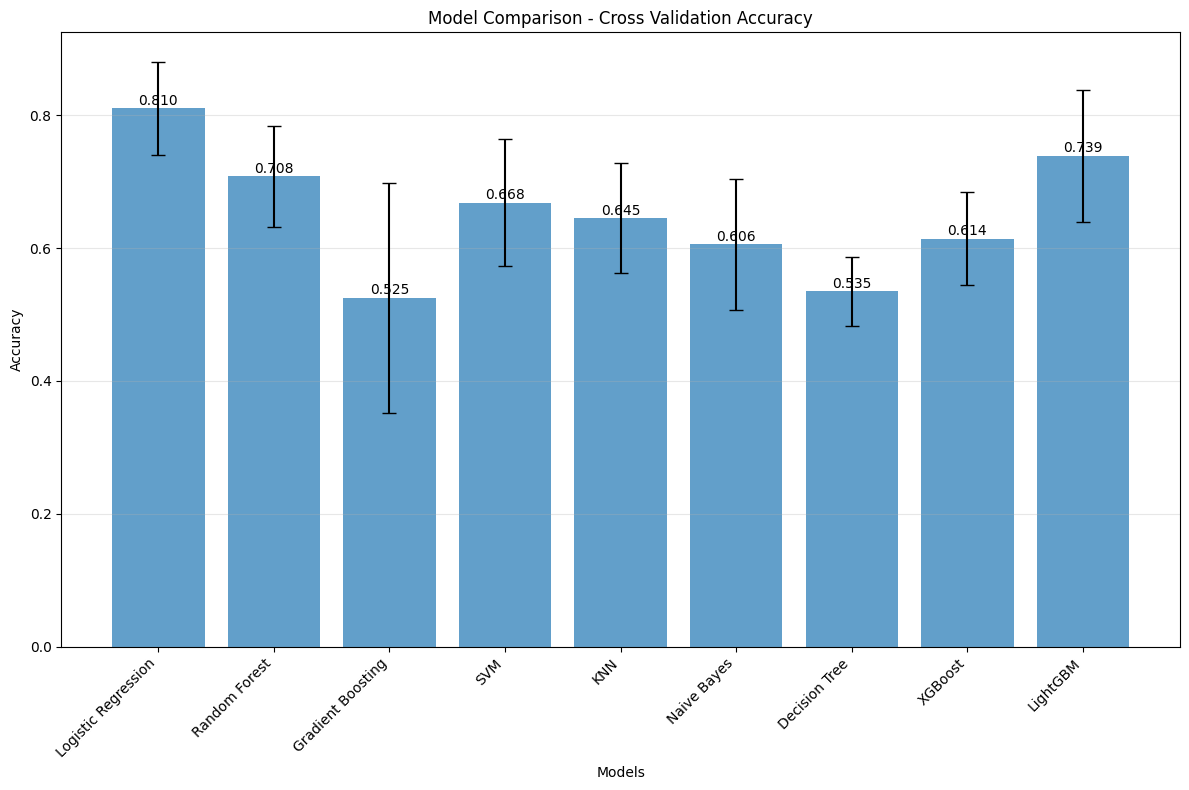


Model ranking by CV accuracy:
1. Logistic Regression: 0.8102 (+/- 0.1408)
2. LightGBM: 0.7388 (+/- 0.1981)
3. Random Forest: 0.7080 (+/- 0.1524)
4. SVM: 0.6683 (+/- 0.1915)
5. KNN: 0.6446 (+/- 0.1659)
6. XGBoost: 0.6138 (+/- 0.1402)
7. Naive Bayes: 0.6055 (+/- 0.1965)
8. Decision Tree: 0.5348 (+/- 0.1035)
9. Gradient Boosting: 0.5249 (+/- 0.3448)


In [11]:
# Visualize CV results
model_names = list(cv_results.keys())
mean_scores = [cv_results[name]['mean_score'] for name in model_names]
std_scores = [cv_results[name]['std_score'] for name in model_names]

# Create bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(model_names, mean_scores, yerr=std_scores, capsize=5, alpha=0.7)
plt.title('Model Comparison - Cross Validation Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, mean_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sort results
sorted_results = sorted(cv_results.items(), key=lambda x: x[1]['mean_score'], reverse=True)
print("\nModel ranking by CV accuracy:")
for i, (name, results) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: {results['mean_score']:.4f} (+/- {results['std_score'] * 2:.4f})")

## 8. Detailed Evaluation of Top Models

In [12]:
# Select top 3 models for detailed evaluation
top_models = dict(sorted_results[:3])
print(f"Top 3 models for detailed evaluation: {list(top_models.keys())}")

# Train and evaluate top models
detailed_results = {}

for name, _ in top_models.items():
    print(f"\nDetailed evaluation of {name}:")
    
    # Get model
    model = models[name]
    
    # Train model
    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_pred = model.predict(X_val_selected)
    y_pred_proba = model.predict_proba(X_val_selected) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    detailed_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    # Classification report
    print(f"\n  Classification Report:")
    print(classification_report(y_val, y_pred, target_names=[f'Class_{i}' for i in np.unique(y_val)]))

Top 3 models for detailed evaluation: ['Logistic Regression', 'LightGBM', 'Random Forest']

Detailed evaluation of Logistic Regression:
  Accuracy: 0.7500
  Precision: 0.7772
  Recall: 0.7500
  F1-Score: 0.7537

  Classification Report:
              precision    recall  f1-score   support

     Class_0       0.62      0.83      0.71         6
     Class_1       0.83      0.71      0.77         7
     Class_2       0.71      0.83      0.77         6
     Class_3       1.00      0.71      0.83         7
     Class_4       0.67      0.67      0.67         6

    accuracy                           0.75        32
   macro avg       0.77      0.75      0.75        32
weighted avg       0.78      0.75      0.75        32


Detailed evaluation of LightGBM:
  Accuracy: 0.5625
  Precision: 0.5881
  Recall: 0.5625
  F1-Score: 0.5482

  Classification Report:
              precision    recall  f1-score   support

     Class_0       0.71      0.83      0.77         6
     Class_1       0.60      0

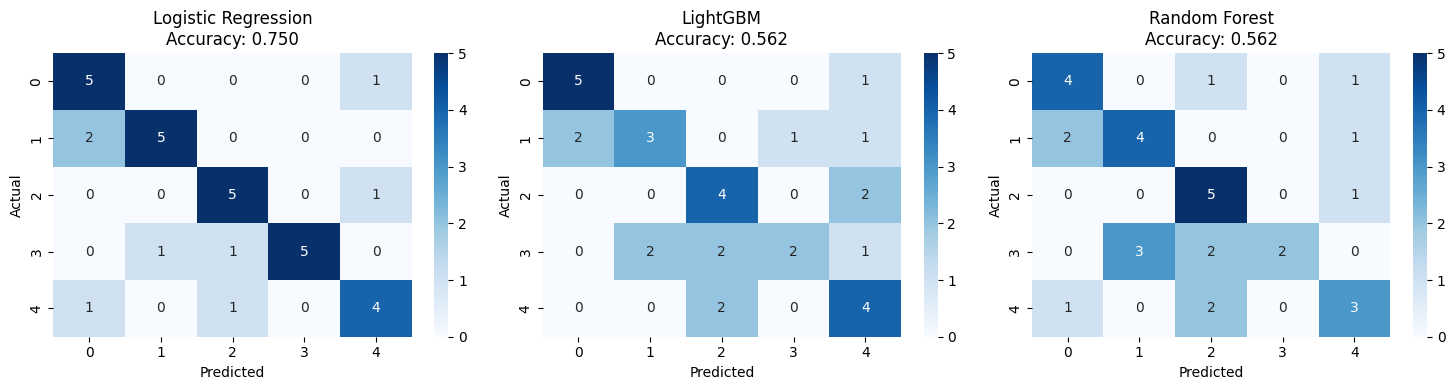

In [13]:
# Confusion matrices for top models
fig, axes = plt.subplots(1, len(top_models), figsize=(15, 4))
if len(top_models) == 1:
    axes = [axes]

for idx, (name, results) in enumerate(detailed_results.items()):
    cm = confusion_matrix(y_val, results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning for Best Model

In [14]:
# Select best model based on validation performance
best_model_name = max(detailed_results.keys(), 
                     key=lambda x: detailed_results[x]['accuracy'])
print(f"Best model for hyperparameter tuning: {best_model_name}")

# Define hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    }
}

# Get appropriate parameter grid
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    
    print(f"Tuning hyperparameters for {best_model_name}...")
    print(f"Parameter grid: {param_grid}")
    
    # Create fresh model instance
    base_model = models[best_model_name]
    
    # Randomized search for efficiency
    random_search = RandomizedSearchCV(
        base_model, param_grid, n_iter=20, cv=3,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    
    # Fit the search
    random_search.fit(X_train_selected, y_train)
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    
    # Get best model
    best_tuned_model = random_search.best_estimator_
    
else:
    print(f"No hyperparameter grid defined for {best_model_name}")
    best_tuned_model = detailed_results[best_model_name]['model']

Best model for hyperparameter tuning: Logistic Regression
Tuning hyperparameters for Logistic Regression...
Parameter grid: {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'lbfgs']}
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best CV score: 0.7879
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best CV score: 0.7879


## 10. Final Model Evaluation

In [15]:
# Evaluate tuned model on validation set
final_predictions = best_tuned_model.predict(X_val_selected)
final_probabilities = best_tuned_model.predict_proba(X_val_selected)

# Calculate final metrics
final_accuracy = accuracy_score(y_val, final_predictions)
final_precision = precision_score(y_val, final_predictions, average='weighted')
final_recall = recall_score(y_val, final_predictions, average='weighted')
final_f1 = f1_score(y_val, final_predictions, average='weighted')

print("=== FINAL MODEL PERFORMANCE ===")
print(f"Model: {best_model_name} (Tuned)")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_val, final_predictions, 
                          target_names=[f'Class_{i}' for i in np.unique(y_val)]))

=== FINAL MODEL PERFORMANCE ===
Model: Logistic Regression (Tuned)
Accuracy: 0.7500
Precision: 0.8058
Recall: 0.7500
F1-Score: 0.7535

Detailed Classification Report:
              precision    recall  f1-score   support

     Class_0       0.62      0.83      0.71         6
     Class_1       1.00      0.57      0.73         7
     Class_2       0.62      0.83      0.71         6
     Class_3       1.00      0.71      0.83         7
     Class_4       0.71      0.83      0.77         6

    accuracy                           0.75        32
   macro avg       0.79      0.76      0.75        32
weighted avg       0.81      0.75      0.75        32



In [16]:
# Feature importance for tree-based models
if hasattr(best_tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_tuned_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 important features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(feature_importance.head(10))
else:
    print(f"Feature importance not available for {best_model_name}")

Feature importance not available for Logistic Regression


## 11. Model Persistence

In [17]:
# Save the best model and preprocessing objects
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model
joblib.dump(best_tuned_model, f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl')

# Save preprocessing objects
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(selector, '../models/feature_selector.pkl')

# Save label encoder if used
if 'le' in locals() and hasattr(le, 'classes_'):
    joblib.dump(le, '../models/label_encoder.pkl')

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_tuned_model).__name__,
    'features_used': len(selected_features),
    'total_features': X.shape[1],
    'validation_accuracy': final_accuracy,
    'validation_f1': final_f1,
    'hyperparameters': best_tuned_model.get_params(),
    'selected_features': selected_features.tolist(),
    'training_date': pd.Timestamp.now().isoformat()
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model and preprocessing objects saved to ../models/ directory")
print(f"Files saved:")
print(f"- best_model_{best_model_name.lower().replace(' ', '_')}.pkl")
print(f"- scaler.pkl")
print(f"- feature_selector.pkl")
print(f"- model_metadata.json")
if 'le' in locals() and hasattr(le, 'classes_'):
    print(f"- label_encoder.pkl")

Model and preprocessing objects saved to ../models/ directory
Files saved:
- best_model_logistic_regression.pkl
- scaler.pkl
- feature_selector.pkl
- model_metadata.json


## 12. Model Comparison Summary

In [18]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV_Mean': [cv_results[name]['mean_score'] for name in cv_results.keys()],
    'CV_Std': [cv_results[name]['std_score'] for name in cv_results.keys()]
})

# Add detailed metrics for top models
for name in detailed_results.keys():
    idx = comparison_df[comparison_df['Model'] == name].index[0]
    comparison_df.loc[idx, 'Val_Accuracy'] = detailed_results[name]['accuracy']
    comparison_df.loc[idx, 'Val_Precision'] = detailed_results[name]['precision']
    comparison_df.loc[idx, 'Val_Recall'] = detailed_results[name]['recall']
    comparison_df.loc[idx, 'Val_F1'] = detailed_results[name]['f1']

# Sort by CV score
comparison_df = comparison_df.sort_values('CV_Mean', ascending=False)

print("=== MODEL COMPARISON SUMMARY ===")
display(comparison_df.round(4))

print(f"\n=== SELECTED MODEL ===")
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {final_accuracy:.4f}")
print(f"Validation F1-Score: {final_f1:.4f}")
print(f"Features Used: {len(selected_features)} out of {X.shape[1]}")

print(f"\n=== NEXT STEPS ===")
print("1. Use the selected model for final training on full dataset")
print("2. Generate predictions on test set")
print("3. Consider ensemble methods if needed")
print("4. Validate model performance on unseen data")

=== MODEL COMPARISON SUMMARY ===


,Model,CV_Mean,CV_Std,Val_Accuracy,Val_Precision,Val_Recall,Val_F1
0,Logistic Regression,0.8102,0.0704,0.7500,0.7772,0.7500,0.7537
8,LightGBM,0.7388,0.0990,0.5625,0.5881,0.5625,0.5482
1,Random Forest,0.7080,0.0762,0.5625,0.6384,0.5625,0.5485
3,SVM,0.6683,0.0957,NaN,NaN,NaN,NaN
4,KNN,0.6446,0.0829,NaN,NaN,NaN,NaN
7,XGBoost,0.6138,0.0701,NaN,NaN,NaN,NaN
5,Naive Bayes,0.6055,0.0983,NaN,NaN,NaN,NaN
6,Decision Tree,0.5348,0.0517,NaN,NaN,NaN,NaN
2,Gradient Boosting,0.5249,0.1724,NaN,NaN,NaN,NaN



=== SELECTED MODEL ===
Best Model: Logistic Regression
Validation Accuracy: 0.7500
Validation F1-Score: 0.7535
Features Used: 1000 out of 22036

=== NEXT STEPS ===
1. Use the selected model for final training on full dataset
2. Generate predictions on test set
3. Consider ensemble methods if needed
4. Validate model performance on unseen data
